In [1]:
import os
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2024-07-01 04:34:12.533789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 04:34:12.533925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 04:34:12.665003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import shutil
import random

In [3]:
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
subfolders = ['train', 'val', 'test']
labels = ['NORMAL', 'PNEUMONIA']
total_images = 0

In [4]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

In [5]:
for subfolder in subfolders:
    for label in labels:
        folder_path = os.path.join(dataset_path, subfolder, label)
        num_images = count_images_in_folder(folder_path)
        total_images += num_images
        print(f'Thư mục {folder_path} có {num_images} hình ảnh')

print(f'Tổng số hình ảnh trong tập dữ liệu: {total_images}')

Thư mục /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL có 1341 hình ảnh
Thư mục /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA có 3875 hình ảnh
Thư mục /kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL có 8 hình ảnh
Thư mục /kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA có 8 hình ảnh
Thư mục /kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL có 234 hình ảnh
Thư mục /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA có 390 hình ảnh
Tổng số hình ảnh trong tập dữ liệu: 5856


In [6]:
output_dataset_path = '/kaggle/working/chest_xray'
os.makedirs(output_dataset_path, exist_ok=True)

for subfolder in subfolders:
    for label in labels:
        folder_path = os.path.join(dataset_path, subfolder, label)
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        random.seed(42)
        random.shuffle(images)
        num_train = int(0.7 * len(images))
        num_val = int(0.1 * len(images))
        num_test = len(images) - num_train - num_val

        train_images = images[:num_train]
        val_images = images[num_train:num_train + num_val]
        test_images = images[num_train + num_val:]

        for split in subfolders:
            os.makedirs(os.path.join(output_dataset_path, split, label), exist_ok=True)

        # Di chuyển hình ảnh vào thư mục mới
        for image in train_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(output_dataset_path, 'train', label, image))
        for image in val_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(output_dataset_path, 'val', label, image))
        for image in test_images:
            shutil.copy(os.path.join(folder_path, image), os.path.join(output_dataset_path, 'test', label, image))


In [7]:
total_images = 0
for subfolder in subfolders:
    for label in labels:
        folder_path = os.path.join(output_dataset_path, subfolder, label)
        num_images = count_images_in_folder(folder_path)
        total_images += num_images
        print(f'Thư mục đã chia {folder_path} có {num_images} hình ảnh')

print(f'Tổng số hình ảnh trong tập dữ liệu: {total_images}')

Thư mục đã chia /kaggle/working/chest_xray/train/NORMAL có 1106 hình ảnh
Thư mục đã chia /kaggle/working/chest_xray/train/PNEUMONIA có 2990 hình ảnh
Thư mục đã chia /kaggle/working/chest_xray/val/NORMAL có 157 hình ảnh
Thư mục đã chia /kaggle/working/chest_xray/val/PNEUMONIA có 426 hình ảnh
Thư mục đã chia /kaggle/working/chest_xray/test/NORMAL có 320 hình ảnh
Thư mục đã chia /kaggle/working/chest_xray/test/PNEUMONIA có 857 hình ảnh
Tổng số hình ảnh trong tập dữ liệu: 5856


In [8]:
train_path= os.path.join(output_dataset_path, 'train')
test_path=os.path.join(output_dataset_path, 'test')
val_path=os.path.join(output_dataset_path, 'val')

In [9]:
batch_size = 64
image_size = (150, 150)

In [10]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = 'binary'
)
test_ds = keras.utils.image_dataset_from_directory(
    directory = test_path,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = 'binary'
)
val_ds = keras.utils.image_dataset_from_directory(
    directory = val_path,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = 'binary'
)

Found 4096 files belonging to 2 classes.
Found 1177 files belonging to 2 classes.
Found 583 files belonging to 2 classes.


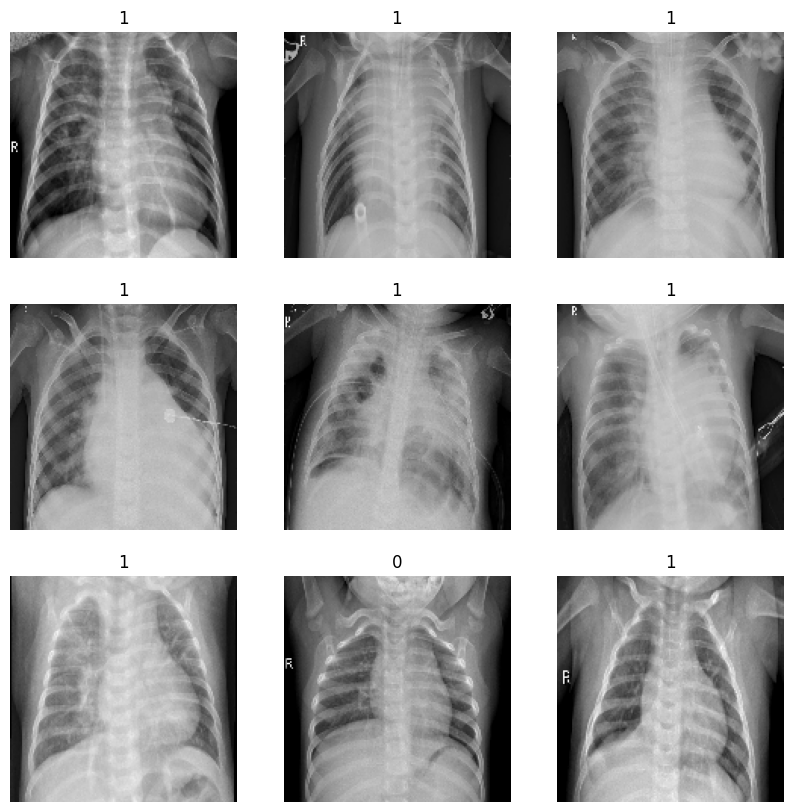

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 1. CNN

In [12]:
model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(6, (3, 3), activation='relu', input_shape=image_size + (3,)))
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add(layers.Conv2D(12, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add(layers.Conv2D(24, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model_CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 12)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 24)     │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,937 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,381 (40.55 KB)

 Trainable params: 10,381 (40.55 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_CNN.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
epochs = 50
hist_CNN = model_CNN.fit(train_ds, epochs = epochs, validation_data = val_ds)

Epoch 1/50
 2/64 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6406 - loss: 48.0187

I0000 00:00:1719808527.921541     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.6501 - loss: 26.4327 - val_accuracy: 0.9177 - val_loss: 0.2326
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9100 - loss: 0.2427 - val_accuracy: 0.9400 - val_loss: 0.1620
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9283 - loss: 0.1816 - val_accuracy: 0.9348 - val_loss: 0.1489
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9439 - loss: 0.1490 - val_accuracy: 0.9297 - val_loss: 0.1431
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9539 - loss: 0.1164 - val_accuracy: 0.9434 - val_loss: 0.1237
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.9628 - loss: 0.1028 - val_accuracy: 0.9451 - val_loss: 0.1361
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9632 - loss: 0.0961 - val_accuracy: 0.9503 - val_loss: 0.1416
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.9657 - loss: 0.0841 - val_accuracy: 0.94

In [16]:
loss, accuracy = model_CNN.evaluate(test_ds)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9407 - loss: 0.2264
Test loss: 0.3050755560398102, Test accuracy: 0.9405267834663391


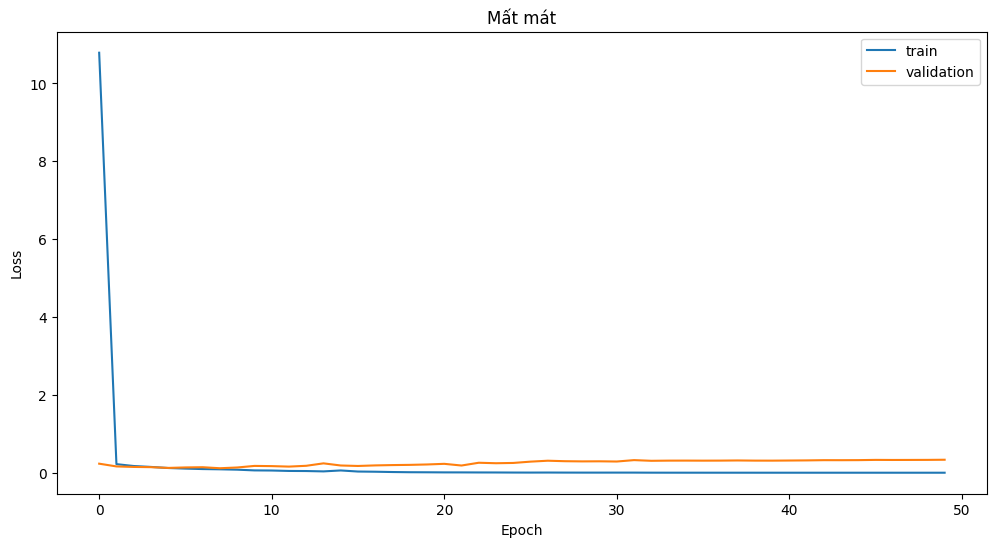

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(hist_CNN.history['loss'], label='train')
plt.plot(hist_CNN.history['val_loss'], label='validation')
plt.title('Mất mát')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [18]:
def plot_hist(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["accuracy"], label='train')
    plt.plot(history.history["val_accuracy"], label='validation')
    plt.title("Độ chính xác của mô hình")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

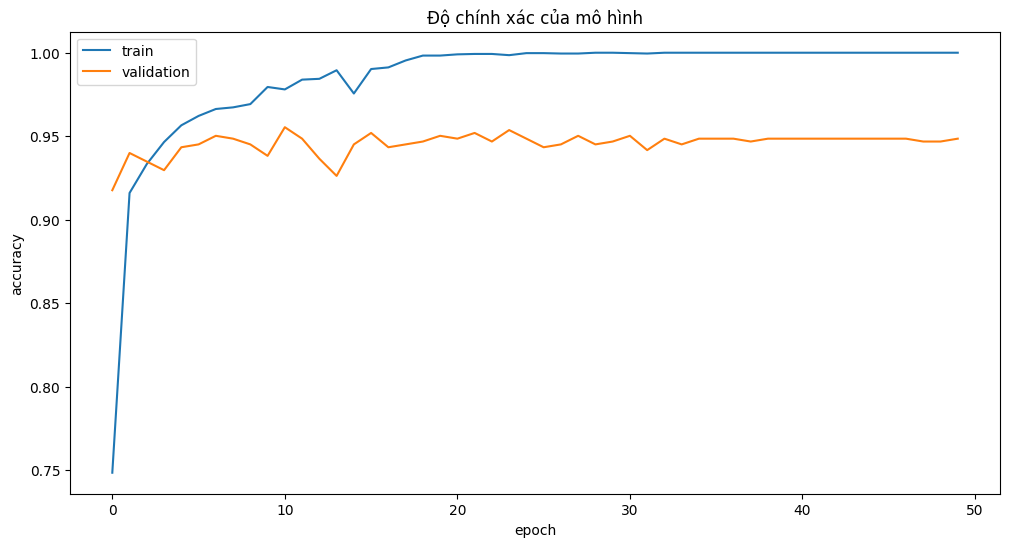

In [19]:
plot_hist(hist_CNN)

In [20]:
model_CNN.save('model_CNN.h5')

# 2. ResNET

In [21]:
base_model = ResNet50(weights='imagenet', include_top=False)
# Thêm lớp phân loại cuối cùng
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)  # 2 lớp đầu ra: "bình thường" và "bất thường"
# Tạo mô hình mới
model_resnet = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model_resnet.layers[-1].trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model_resnet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
model_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
hist_resnet = model_resnet.fit(train_ds, epochs = epochs, validation_data = val_ds)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - accuracy: 0.7779 - loss: 0.4886 - val_accuracy: 0.9280 - val_loss: 0.1794
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.9268 - loss: 0.1907 - val_accuracy: 0.9331 - val_loss: 0.1649
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.9456 - loss: 0.1537 - val_accuracy: 0.9503 - val_loss: 0.1430
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.9554 - loss: 0.1358 - val_accuracy: 0.9554 - val_loss: 0.1274
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9584 - loss: 0.1243 - val_accuracy: 0.9571 - val_loss: 0.1208
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9641 - loss: 0.1100 - val_accuracy: 0.9623 - val_loss: 0.1207
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9651 - loss: 0.1101 - val_accuracy: 0.9657 - val_loss: 0.1133
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.9678 - loss: 0.1018 - val_accu

In [25]:
loss, accuracy = model_resnet.evaluate(test_ds)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.9545 - loss: 0.1206
Test loss: 0.11202114820480347, Test accuracy: 0.9549702405929565


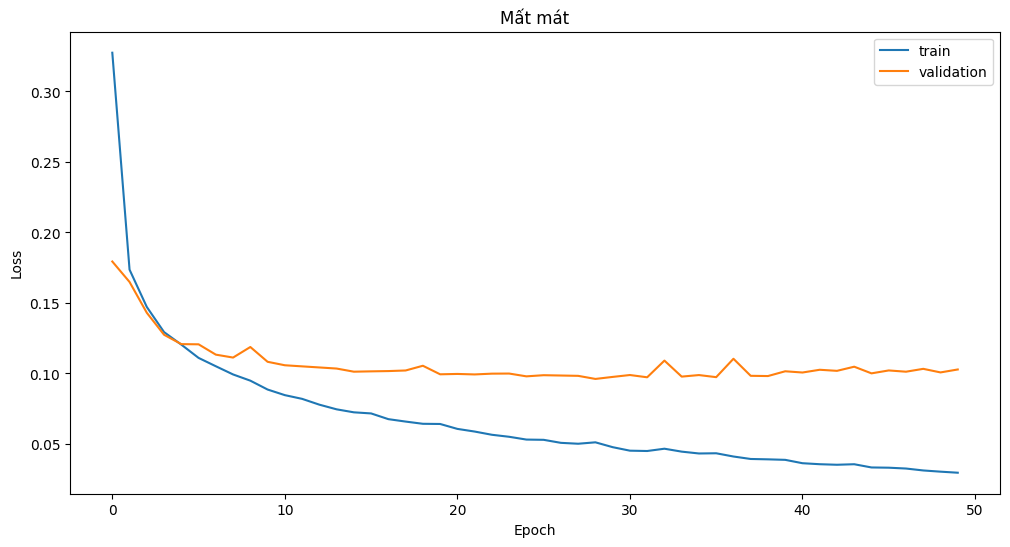

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(hist_resnet.history['loss'], label='train')
plt.plot(hist_resnet.history['val_loss'], label='validation')
plt.title('Mất mát')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

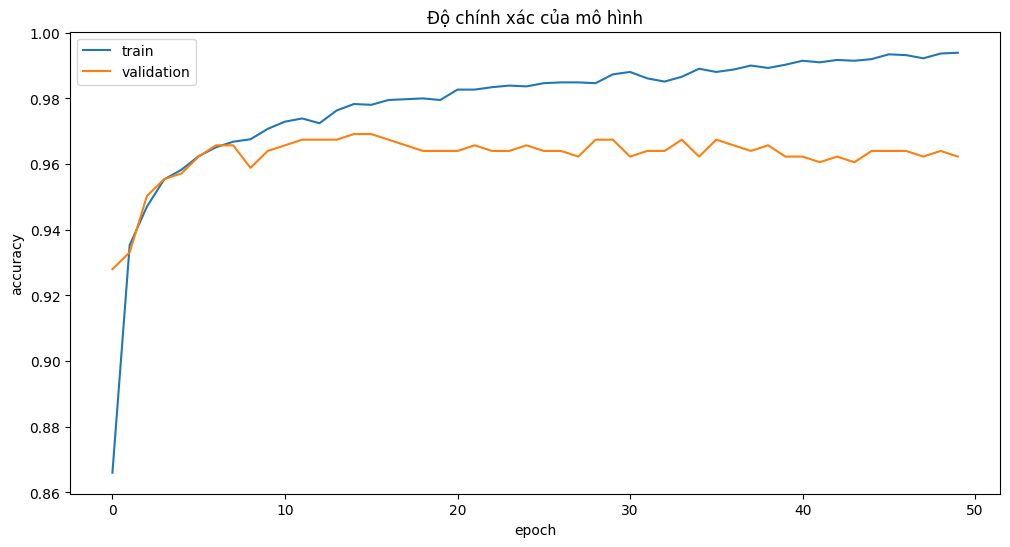

In [27]:
plot_hist(hist_resnet)

In [28]:
model_resnet.save('model_resnet.h5')

# 3. DenseNET

In [29]:
from keras.applications import DenseNet121

In [30]:
base_model = DenseNet121(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model_densenet = Model(inputs=base_model.input, outputs=x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
model_densenet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [32]:
model_densenet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
hist_densenet = model_densenet.fit(train_ds, epochs = epochs, validation_data = val_ds)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 211s 681ms/step - accuracy: 0.8875 - loss: 0.2873 - val_accuracy: 0.7307 - val_loss: 17.6924
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - accuracy: 0.9695 - loss: 0.0835 - val_accuracy: 0.8971 - val_loss: 0.4912
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.9754 - loss: 0.0679 - val_accuracy: 0.9554 - val_loss: 0.1405
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - accuracy: 0.9835 - loss: 0.0538 - val_accuracy: 0.8851 - val_loss: 0.4123
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.9849 - loss: 0.0442 - val_accuracy: 0.9022 - val_loss: 0.3187
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.9897 - loss: 0.0285 - val_accuracy: 0.9708 - val_loss: 0.1079
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.9889 - loss: 0.0282 - val_accuracy: 0.8542 - val_loss: 0.8243
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.9958 - loss: 0.0151 - val_ac

In [34]:
loss, accuracy = model_densenet.evaluate(test_ds)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 942ms/step - accuracy: 0.9758 - loss: 0.2022
Test loss: 0.14186137914657593, Test accuracy: 0.9787595868110657


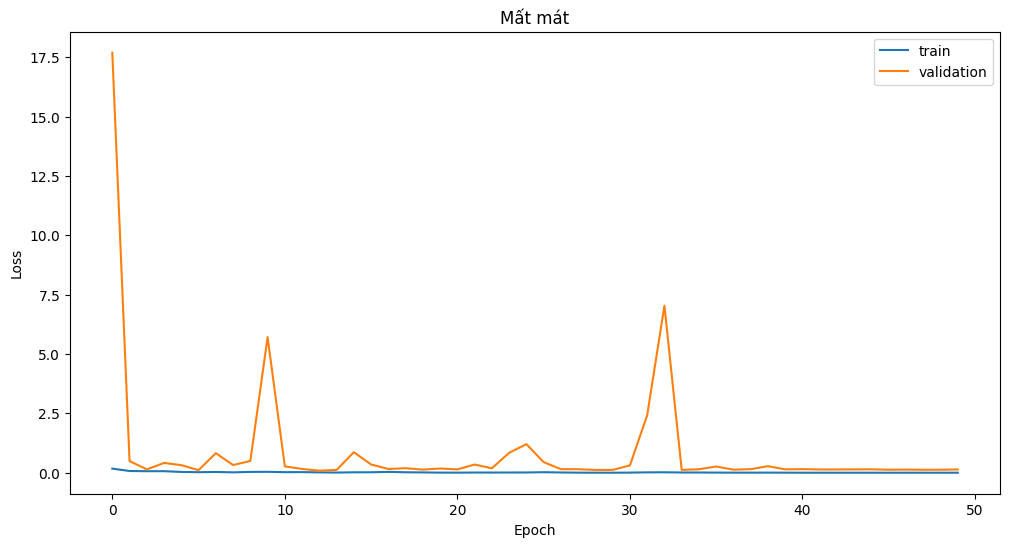

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(hist_densenet.history['loss'], label='train')
plt.plot(hist_densenet.history['val_loss'], label='validation')
plt.title('Mất mát')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

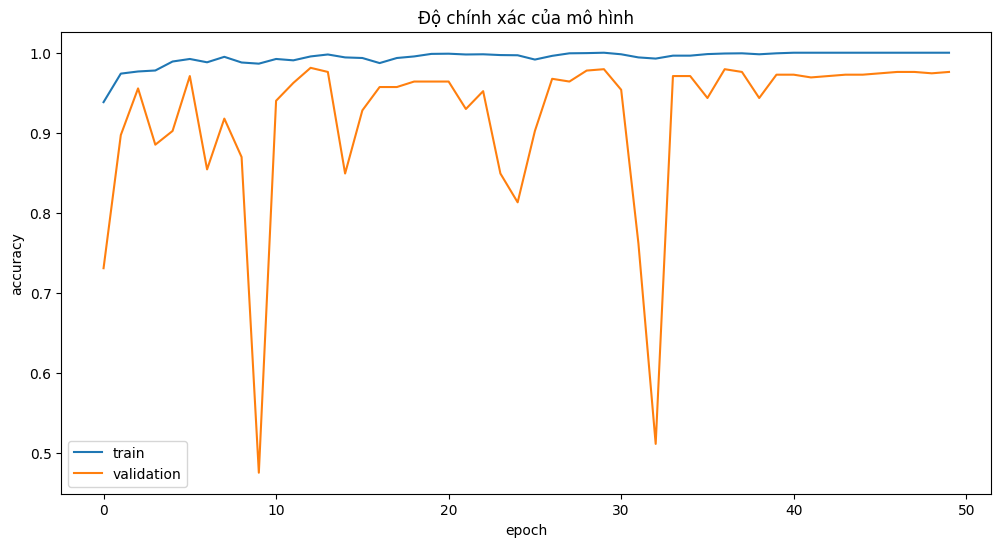

In [36]:
plot_hist(hist_densenet)

In [37]:
model_densenet.save('model_densenet.h5')

In [38]:
import pandas as pd

In [39]:
histories = [hist_CNN, hist_resnet, hist_densenet]

model_stats = {}

for i, history in enumerate(histories, 1):
    
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    model_stats[f'Model{i}'] = {
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
    }

df = pd.DataFrame(model_stats).T
print(df)

        Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
Model1        1.000000             0.948542    0.000280         0.333727
Model2        0.993896             0.962264    0.029615         0.102828
Model3        1.000000             0.975986    0.000031         0.137926
